#### Important
Make sure your install minisom before working on this notebook. If you work on Jupyterlab, you will need to install it again every time you start the server.

To install minisom, open a terminal, use the command:
`pip install minisom`

In [1]:
import minisom
from minisom import MiniSom
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

## Recap about Self-organizing map (SOM)

<a title="Chompinha, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:TrainSOM.gif"><img width="256" alt="TrainSOM" src="https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif"></a>

The self-organizing map is a grid in the high-dimensional space spanned by your dataset(the number of dimension is the number of features in your dataset).  For each node in the map, its coordinate in the multi-dimensional space is called the weight of the node. The training process of the self-organizing map is essentially updating the weight(i.e. coordinate) of the nodes to make them as close as possible to the dataset points. 

By the end of the training process, each data point in the dataset will find a nearest node in the map, and this node is called the `best matching unit` of this data point. Though the training happens in the high-dimensional space, you can display the map as a two-dimensional grid(Imagine you flatten a crumbled paper). And on the two-dimensional grid, you can show the location of each `best matching unit`, which reflects the clustering of your datapoints in the high-dimensional space.

ref: https://www.sciencedirect.com/science/article/pii/S2590048X19300202

## Train SOM with the periodic table data

In [2]:
periodic = pd.read_csv('https://gist.githubusercontent.com/GoodmanSciences/c2dd862cd38f21b0ad36b8f96b4bf1ee/raw/1d92663004489a5b6926e944c1b3d9ec5c40900e/Periodic%2520Table%2520of%2520Elements.csv')

Here we use only a subset of the data. Rows with NaN values are dropped.

In [3]:
sub = periodic[['AtomicNumber', 'Element', 'Symbol','Period','Group','MeltingPoint','BoilingPoint','FirstIonization','Density']].copy()
sub.dropna(inplace=True)

# Set a new index of this subset data
sub['index']=list(range(len(sub)))
sub.set_index('index',drop=True,inplace=True)

In [4]:
sub

,AtomicNumber,Element,Symbol,Period,Group,MeltingPoint,BoilingPoint,FirstIonization,Density
index,,,,,,,,,
0,1,Hydrogen,H,1,1.0,14.175,20.28,13.5984,0.00009
1,3,Lithium,Li,2,1.0,453.850,1615.00,5.3917,0.53400
2,4,Beryllium,Be,2,2.0,1560.150,2742.00,9.3227,1.85000
3,5,Boron,B,2,13.0,2573.150,4200.00,8.2980,2.34000
4,6,Carbon,C,2,14.0,3948.150,4300.00,11.2603,2.27000
...,...,...,...,...,...,...,...,...,...
69,85,Astatine,At,6,17.0,575.150,610.00,9.3000,7.00000
70,86,Radon,Rn,6,18.0,202.150,211.30,10.7485,0.00973
71,87,Francium,Fr,7,1.0,300.150,950.00,4.0727,1.87000


We will use the MeltingPoint,BoilingPoint,FirstIonization,Density values of our data to train the SOM. Note that only the numerical data can be used to train SOM, but the categorical data can be useful when we visualize the SOM later.

It's important to normalize the data before training a SOM.

In [5]:
traindata = sub[['MeltingPoint','BoilingPoint','FirstIonization','Density']].values
traindata = (traindata - np.mean(traindata, axis=0)) / np.std(traindata, axis=0) 
#axis=0 to take the normalization bu column 

Train the SOM with this `traindata` array.

Important parameters: 

`sigma`: it determines the radius of neighbors on the map. Note that when we update the location of each node in the map, its neighbors in the map will be updated together. sigma determines a radius that all the other nodes within this range will be regarded as neighbors.

`learning_rate`: it determines how much weights are updated in each iteration of training.

In [6]:
# Define a SOM
height = 10
width = 10
# Define a MiniSom object
som = MiniSom(width, height, traindata.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=0) 

# Initialize the weights by PCA
som.pca_weights_init(traindata)

# trains the SOM with 400 iterations
som.train(traindata, 400) 

We can visualize the trained SOM by displaying the all the `best matching unit` in the grid.

This will use the `winner()` method of this `MiniSom` object. It takes in the training data value of one data point (i.e. one row in our `traindata` array), and returns the coordinate of its `best matching unit` in the grid.

For example:

In [7]:
som.winner(traindata[0])

(0, 5)

This means that the `best matching unit` of the our first data point is the (0,5) node in the grid. 

Then we can write a loop to display the `best matching unit` of all our data points on our map.

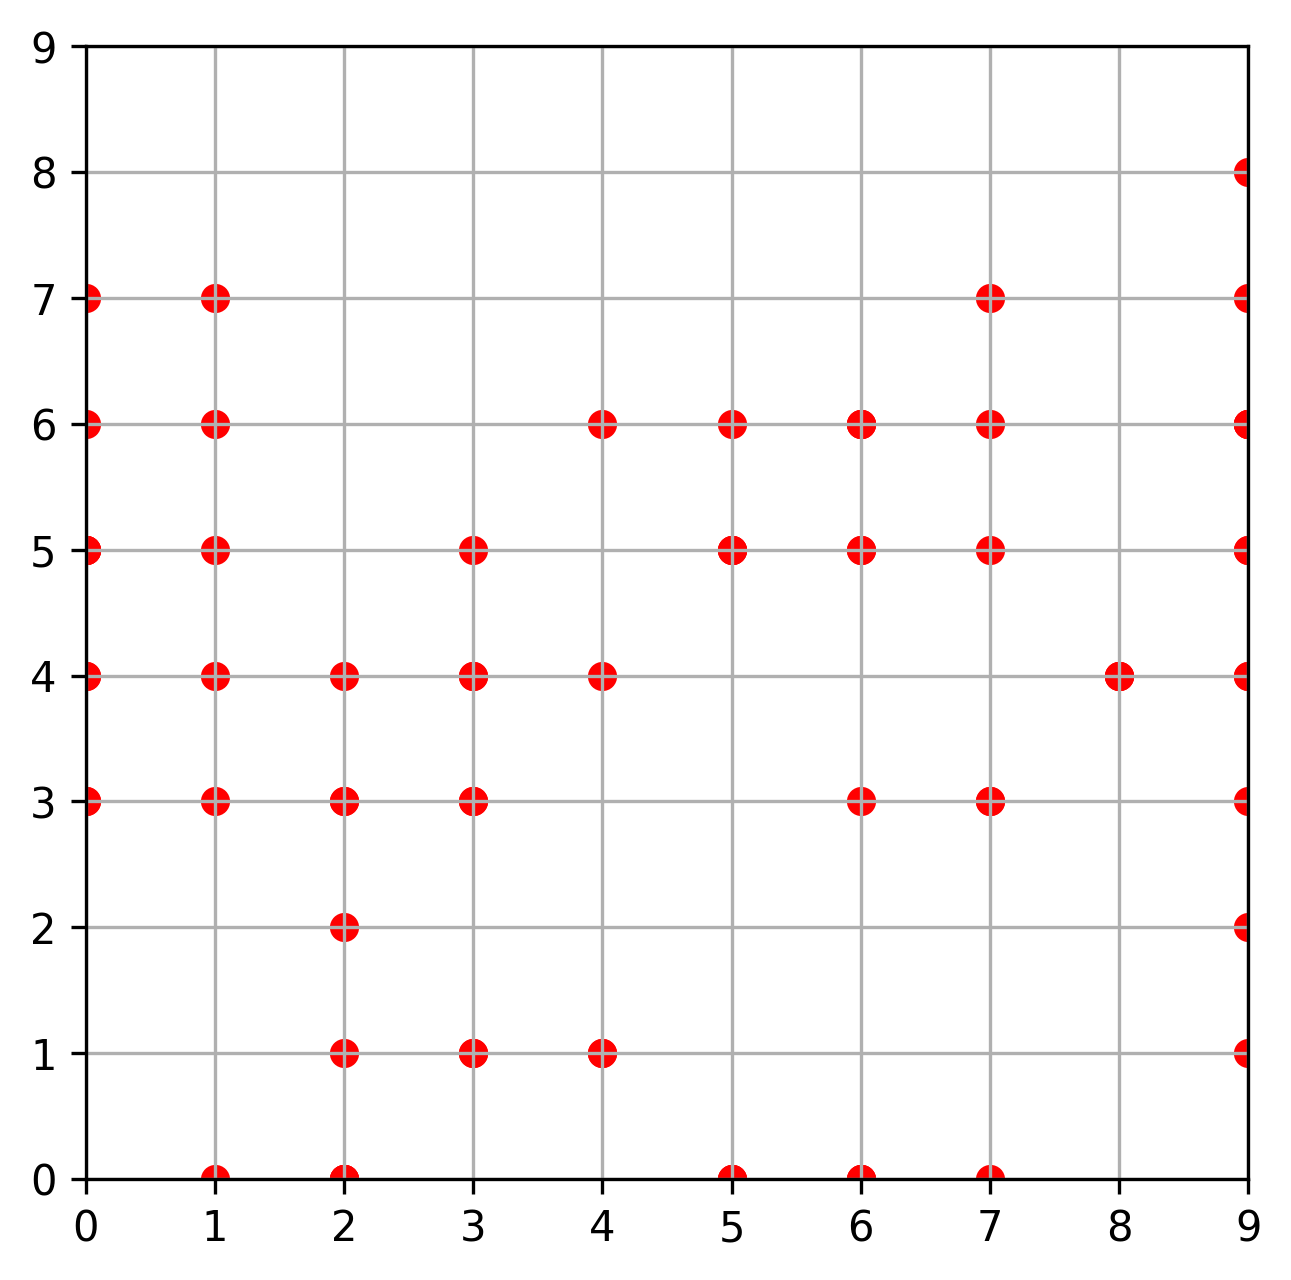

In [8]:
fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(traindata):
    # find the best matching unit of the datapoint
    w = som.winner(datapoint)
    x_coord = w[0]
    y_coord = w[1]
    
    #plot the best matching unit
    plt.scatter(x_coord,y_coord,c='red')
    
#visualize the grid    
plt.ylim(0,height-1)
plt.xlim(0,width-1)
ax.set_xticks(range(width))
ax.set_yticks(range(height))
plt.grid()

### Exercise 1: Please find the coordinate of the `best matching unit` of Sodium in the grid

We would find from the above plot that, the amount of displayed points is less than the number of data points in our training data. This is because the many data points share the same node as the `best matching unit`. 

When plot the `best matching unit` the we can add a small random offset to their coordinate in the grid to make them distinguishable. And the element symbol of their corresponding datapoint can be displayed next to the points in the grid.

Also, we can color-encode each `best matching unit` by the category of their corresponding datapoint. In the example below, we plot all the `best matching unit` corresponding to Group I elements in red, and all other `best matching unit` in blue.

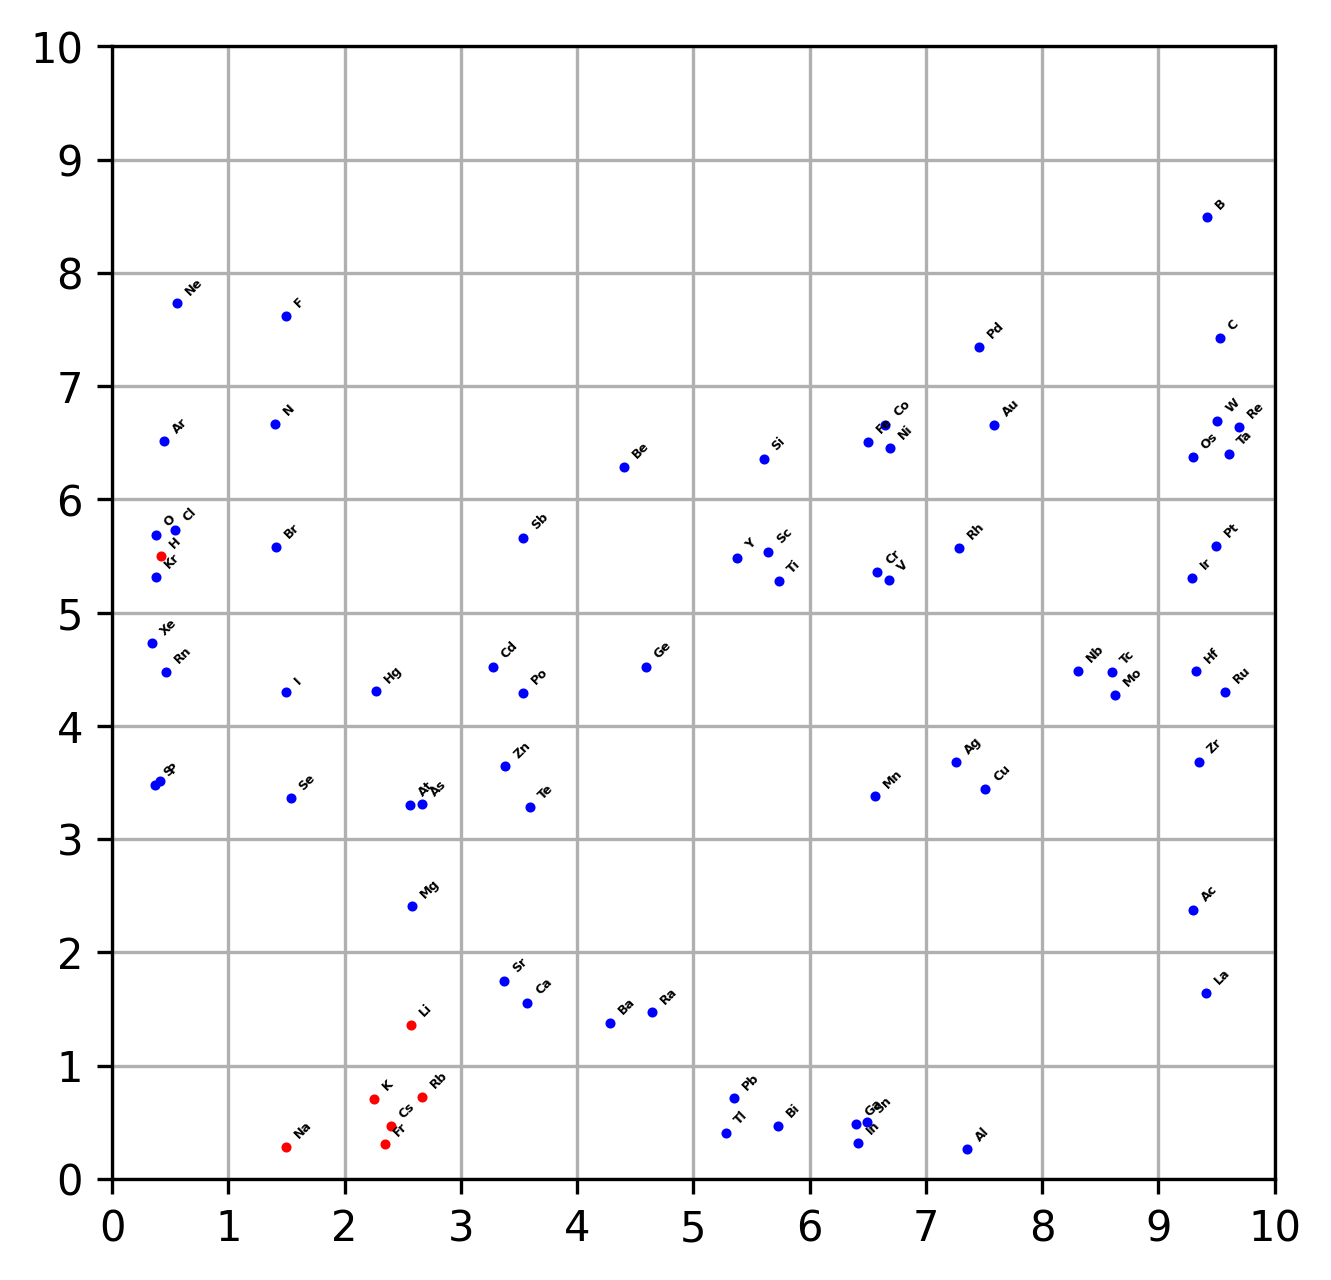

In [9]:
fig = plt.figure(figsize=(5, 5),dpi=300)
ax = fig.add_subplot(111)

for index, datapoint in enumerate(traindata):
    w = som.winner(datapoint)  
    
    #add a random offset to their coordinate in the grid
    x_coord = w[0]+np.random.uniform(0.25,0.75)
    y_coord = w[1]+np.random.uniform(0.25,0.75)
    
    # color-encode by Group
    # the 'index' corresponds to the index in the training dataset
    if sub.iloc[index]['Group']==1:
        plt.scatter(x_coord,y_coord,c='red',s=2)
    else:
        plt.scatter(x_coord,y_coord,c='blue',s=2)
    
    # add label next to each point.
    plt.text(x_coord+0.05,y_coord+0.05,sub.iloc[index]['Symbol'],
            horizontalalignment='left', verticalalignment='bottom',
            rotation=45, fontsize=3, weight='semibold')
    
plt.xlim(0,10)
plt.ylim(0,10)
ax.set_xticks(range(11))
ax.set_yticks(range(11))
plt.grid()

plt.show()

* From the above plot we find that all the Group I elements except Hydrogen are gathered close together on the map.

### Exercise 2: make a new plot like the one right above, but display each `best matching unit` corresponding to elements in period 4 in red, and the other `best matching unit` in blue.

### Question: are there any elements in period 4 located close together on your map? What does this indicate about the Euclidean distance between their training data points?



## Evaluate the quantization and topographic error of SOM

* Quantization error: Average distance between each data point and its `Best matching unit`
* Topographic error: the proportion of all data vectors for which first and second `Best matching unit` are not adjacent units.Measures topology preservation.


In [151]:
print('Topographic error: ', som.topographic_error(traindata))
print('Quantization error: ', som.quantization_error(traindata))

Topographic error:  0.04054054054054054
Quantization error:  0.24475788420991096


Let's tune the size of the map,  and see if we can find lower topographic error and quantization error.
Assume it's a square grid.

In [152]:
size_list = np.arange(5,25,1)
te = [0]*len(size_list)
qe = [0]*len(size_list)

for i in range(len(size_list)):
    som = MiniSom(size_list[i], size_list[i], traindata.shape[1], sigma=1.0, learning_rate=0.5,neighborhood_function='gaussian', random_seed=0)
    som.pca_weights_init(traindata)
    som.train(traindata, 400)
    te[i] = som.topographic_error(traindata)
    qe[i] = som.quantization_error(traindata)

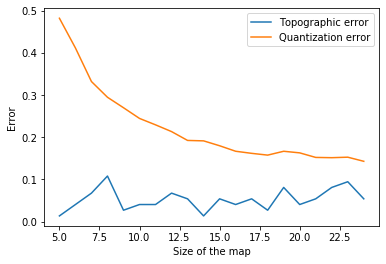

In [153]:
plt.plot(size_list,te,label='Topographic error')
plt.plot(size_list,qe,label='Quantization error')
plt.xlabel('Size of the map')
plt.ylabel('Error')
plt.legend()
plt.show()

### Exercise 3: Please write a loop to see how topographic error and quantization error change with the parameter `sigma` from 0.5 to 5, then make a plot of topographic error and quantization error as function of sigma.